In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import streamlit as st
import newspaper
from newspaper import Article
import nltk
from nltk.tokenize import word_tokenize
import time
import re

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetRegressor
import shap

In [59]:
nltk.download('punkt', quiet = True)

True

In [60]:
st.set_page_config(page_title = "大阪市 物件過熱度ダッシュボード", layout = "wide")

2025-08-04 23:36:02.018 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [61]:
#不動産データ
try:
    df_pre = pd.read_csv("/home/shizuku/re-voltage/re-voltage/data/raw/used_redata.csv", encoding="932")
    df_pre = df_pre.rename(columns = {"市区町村名" : "area", "取引価格（総額）" : "price", "取引時期" : "year", "最寄駅：距離（分）" : "distance", "建築年" : "built_year", "市区町村コード" : "area_code"})
    df_pre["year"] = df_pre["year"].apply(lambda x:int(re.search(r'\d{4}', str(x)).group()) if re.search(r'\d{4}', str(x)) else None)
    if df_pre["year"].isnull().any():
        st.warning("「year（取引時期）」列に無効な値があります。該当行を削除します。")
        df_pre["year"] = df_pre["year"].astype("int64")
except FileNotFoundError:
    st.error("不動産データが見つかりません！仮データを使用します")
    data = {
        'area': ['大阪市中央区', '大阪市中央区', '大阪市北区', '大阪市北区', '大阪市天王寺区', '大阪市天王寺区', '大阪市福島区', '大阪市福島区'],
        '取引価格（総額）': [7500, 9000, 6500, 7800, 6000, 6800, 5000, 5500], 
        '取引時期': [2020, 2024, 2020, 2024, 2020, 2024, 2020, 2024], 
        '最寄駅：距離（分）': [3, 3, 4, 4, 5, 5, 4, 4], 
        '建築年': [2010, 2010, 2008, 2008, 2005, 2005, 2000, 2000]
    }
    df_pre = pd.DataFrame(data)

/tmp/ipykernel_1697/2995974502.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pre = pd.read_csv("/home/shizuku/re-voltage/re-voltage/data/raw/used_redata.csv", encoding="932")


In [62]:
df_demo = pd.read_csv("/home/shizuku/re-voltage/re-voltage/data/raw/used_demodata.csv", encoding="932")

In [63]:
df_demo = df_demo.replace("-" , "0")
df_demo = df_demo.rename(columns = {"都道府県・市部－郡部－市区町村別 コード" : "area_code"})
df_demo["year"] = df_demo["時間軸(年次) コード"].astype(str).str[:4]
df_demo.head()

,時間軸(年次) コード,時間軸(年次) 補助コード,時間軸(年次),area_code,都道府県・市部－郡部－市区町村別 補助コード,都道府県・市部－郡部－市区町村別,/人口動態総覧,出生数【人】,2500g未満出生数【人】,死亡数【人】,乳児（１歳未満）死亡数【人】,新生児（生後4週未満）死亡数【人】,自然死産数【胎】,人工死産数【胎】,周産期死亡数【胎・人】,妊娠満22週以後の死産数【胎】,早期新生児（生後1週未満）死亡数【人】,婚姻件数【組】,離婚件数【組】,year
0,2023000000,NaN,2023年,1000,NaN,北海道,NaN,"24,430","2,468","75,120",38,19,261,374,89,72,17,"17,281","8,629",2023
1,2023000000,NaN,2023年,1020,NaN,その他の市,NaN,"10,373","1,012","35,925",15,9,113,167,38,29,9,"7,033","3,846",2023
2,2023000000,NaN,2023年,1030,NaN,郡部,NaN,"3,705",361,"15,352",5,3,43,38,13,10,3,"2,340","1,225",2023
3,2023000000,NaN,2023年,1010,NaN,札幌市,NaN,"10,352","1,095","23,843",18,7,105,169,38,33,5,"7,908","3,558",2023
4,2023000000,NaN,2023年,1101,NaN,中央区,NaN,"1,332",150,"2,684",2,0,13,39,4,4,0,"1,344",527,2023


In [64]:
df_demo["year"] = df_demo["year"].astype('int64')

In [65]:
print(df_pre.dtypes)

種類             object
価格情報区分         object
area_code       int64
都道府県名          object
area           object
地区名            object
最寄駅：名称         object
distance       object
price           int64
間取り            object
面積（㎡）          object
built_year     object
建物の構造          object
用途             object
今後の利用目的        object
都市計画           object
建ぺい率（％）       float64
容積率（％）        float64
year            int64
改装             object
取引の事情等         object
dtype: object


In [66]:
print(df_demo.dtypes)
print(df_demo.isna().sum())

時間軸(年次) コード                 int64
時間軸(年次) 補助コード             float64
時間軸(年次)                    object
area_code                   int64
都道府県・市部－郡部－市区町村別 補助コード    float64
都道府県・市部－郡部－市区町村別           object
/人口動態総覧                   float64
出生数【人】                     object
2500g未満出生数【人】              object
死亡数【人】                     object
乳児（１歳未満）死亡数【人】             object
新生児（生後4週未満）死亡数【人】          object
自然死産数【胎】                   object
人工死産数【胎】                   object
周産期死亡数【胎・人】                object
妊娠満22週以後の死産数【胎】            object
早期新生児（生後1週未満）死亡数【人】        object
婚姻件数【組】                    object
離婚件数【組】                    object
year                        int64
dtype: object
時間軸(年次) コード                   0
時間軸(年次) 補助コード             18524
時間軸(年次)                       0
area_code                     0
都道府県・市部－郡部－市区町村別 補助コード    18524
都道府県・市部－郡部－市区町村別              0
/人口動態総覧                   18524
出生数【人】                        0
2500g未満出生数【人】                 0
死亡数【人】            

In [67]:
df_redemo_pre = df_pre.merge(df_demo, on = ["area_code", "year"], how = 'inner')

In [68]:
cols_to_convert = ['出生数【人】', '2500g未満出生数【人】', '死亡数【人】', '乳児（１歳未満）死亡数【人】', \
                    '新生児（生後4週未満）死亡数【人】', '新生児（生後4週未満）死亡数【人】', '自然死産数【胎】', \
                        '人工死産数【胎】', '周産期死亡数【胎・人】', '妊娠満22週以後の死産数【胎】', \
                            '早期新生児（生後1週未満）死亡数【人】', '婚姻件数【組】', '離婚件数【組】']

for col in cols_to_convert:
    df_redemo_pre[col] = (
        df_redemo_pre[col]
        .astype(str)             # 念のため文字列化
        .str.replace(",", "")    # カンマ削除
        .str.strip()             # 余分な空白を除去
        .replace("nan", pd.NA)   # 文字列 "nan" → 真の欠損扱いに
        .astype("Int64")         # 欠損に対応できる整数型へ
    )

In [69]:
df_redemo_pre['built_year'] = df_redemo_pre['built_year'].str.slice(0,4)
df_redemo_pre = df_redemo_pre[pd.to_numeric(df_redemo_pre['built_year'], errors='coerce').notna()]
df_redemo_pre['built_year'] = df_redemo_pre['built_year'].astype(int)

In [70]:
print(df_redemo_pre.isna().sum())

種類                            0
価格情報区分                        0
area_code                     0
都道府県名                         0
area                          0
地区名                           0
最寄駅：名称                      242
distance                   2006
price                         0
間取り                        5115
面積（㎡）                         0
built_year                    0
建物の構造                      1345
用途                        36105
今後の利用目的                   30296
都市計画                       3922
建ぺい率（％）                   26243
容積率（％）                    26243
year                          0
改装                        34533
取引の事情等                    82252
時間軸(年次) コード                   0
時間軸(年次) 補助コード             82714
時間軸(年次)                       0
都道府県・市部－郡部－市区町村別 補助コード    82714
都道府県・市部－郡部－市区町村別              0
/人口動態総覧                   82714
出生数【人】                        0
2500g未満出生数【人】                 0
死亡数【人】                        0
乳児（１歳未満）死亡数【人】                0
新生児（生後4週

In [71]:
df_redemo_pre = df_redemo_pre[pd.to_numeric(df_redemo_pre['distance'], errors='coerce').notna()]
df_redemo_pre = df_redemo_pre[pd.to_numeric(df_redemo_pre['面積（㎡）'], errors='coerce').notna()]
df_redemo_pre = df_redemo_pre[pd.to_numeric(df_redemo_pre['建ぺい率（％）'], errors='coerce').notna()]
df_redemo_pre = df_redemo_pre[pd.to_numeric(df_redemo_pre['容積率（％）'], errors='coerce').notna()]
# df_redemo_pre = df_redemo_pre.dropna(subset=['離婚件数【組】'])
df_redemo_pre['distance'] = df_redemo_pre['distance'].astype(int)
df_redemo_pre['面積（㎡）'] = df_redemo_pre['面積（㎡）'].astype(int)
df_redemo_pre['建ぺい率（％）'] = df_redemo_pre['建ぺい率（％）'].astype(int)
df_redemo_pre['容積率（％）'] = df_redemo_pre['容積率（％）'].astype(int)

df_redemo = df_redemo_pre.drop(columns=['area', '時間軸(年次) コード', '時間軸(年次)', '都道府県・市部－郡部－市区町村別', '/人口動態総覧'])

In [72]:
print(df_redemo_pre.dtypes)

種類                         object
価格情報区分                     object
area_code                   int64
都道府県名                      object
area                       object
地区名                        object
最寄駅：名称                     object
distance                    int64
price                       int64
間取り                        object
面積（㎡）                       int64
built_year                  int64
建物の構造                      object
用途                         object
今後の利用目的                    object
都市計画                       object
建ぺい率（％）                     int64
容積率（％）                      int64
year                        int64
改装                         object
取引の事情等                     object
時間軸(年次) コード                 int64
時間軸(年次) 補助コード             float64
時間軸(年次)                    object
都道府県・市部－郡部－市区町村別 補助コード    float64
都道府県・市部－郡部－市区町村別           object
/人口動態総覧                   float64
出生数【人】                      Int64
2500g未満出生数【人】               Int64
死亡数【人】        

In [73]:
print(df_redemo)

             種類     価格情報区分  area_code 都道府県名  地区名 最寄駅：名称  distance     price  \
613    中古マンション等  不動産取引価格情報      27102   大阪府  網島町  大阪城北詰         5  29000000   
614    中古マンション等  不動産取引価格情報      27102   大阪府  網島町  大阪城北詰         3  18000000   
615    中古マンション等  不動産取引価格情報      27102   大阪府  網島町  大阪城北詰         3  17000000   
616    中古マンション等  不動産取引価格情報      27102   大阪府  網島町  大阪城北詰         3  17000000   
617    中古マンション等  不動産取引価格情報      27102   大阪府  網島町  大阪城北詰         5  19000000   
...         ...        ...        ...   ...  ...    ...       ...       ...   
83741  中古マンション等  不動産取引価格情報      27366   大阪府   淡輪     淡輪        10   6000000   
83742  中古マンション等  不動産取引価格情報      27366   大阪府   淡輪     淡輪         8   5000000   
83743  中古マンション等  不動産取引価格情報      27366   大阪府   淡輪     淡輪         8   6400000   
83744  中古マンション等  不動産取引価格情報      27366   大阪府   淡輪     淡輪        10   4500000   
83745  中古マンション等  不動産取引価格情報      27366   大阪府   淡輪  みさき公園         3   7500000   

        間取り  面積（㎡）  ...  死亡数【人】 乳児（１歳未満）死亡数【人】 新生児（

In [74]:
# そもそもint列はそのままLightGBMにかけられるので不要
# int_cols = sorted(df_redemo.select_dtypes(include='int').columns)
# other_cols = [col for col in df_redemo.columns if col not in int_cols]
# df_redemo = df_redemo[int_cols + other_cols]  # ここで列の並び替えだけ行っている！

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X = df_redemo.loc[:, (df_redemo.columns!="price")]
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X[cat_cols] = X[cat_cols].astype(str)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
X = X.astype({col: 'float32' for col in X.select_dtypes('bool').columns}).fillna(-1).astype(int)
# 本当はint型(連続値)でなくcategory型やstr型がよさそう。今回はTabNet用に.fillna(-1).astype(int)入れている。

nunique = X.nunique()
useful_cols = nunique[nunique > 1].index
X = X[useful_cols]

y = df_redemo["price"]
y = np.log10(y)

/tmp/ipykernel_1697/2862851529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].astype(str)
/tmp/ipykernel_1697/2862851529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = encoder.fit_transform(X[cat_cols])


In [76]:
print(X)

       area_code   地区名  最寄駅：名称  distance  間取り  面積（㎡）  built_year  建物の構造  用途  \
613        27102  1187     134         5   17     70        1975      6   4   
614        27102  1187     134         3    5     20        2015      3   4   
615        27102  1187     134         3    5     20        2015      3   4   
616        27102  1187     134         3    5     20        2015      3   4   
617        27102  1187     134         5   24     60        1975      6   4   
...          ...   ...     ...       ...  ...    ...         ...    ...  ..   
83741      27366  1014     295        10   24     60        1994      6   4   
83742      27366  1014     295         8    8     50        1987      3   4   
83743      27366  1014     295         8   24     65        1987      3   4   
83744      27366  1014     295        10    8     45        1987      3   4   
83745      27366  1014       6         3   24     65        1996      3   4   

       今後の利用目的  ...  死亡数【人】  乳児（１歳未満）死亡数【人】  新生児（生後

In [77]:
print(X.dtypes)

area_code              int64
地区名                    int64
最寄駅：名称                 int64
distance               int64
間取り                    int64
面積（㎡）                  int64
built_year             int64
建物の構造                  int64
用途                     int64
今後の利用目的                int64
都市計画                   int64
建ぺい率（％）                int64
容積率（％）                 int64
year                   int64
改装                     int64
取引の事情等                 int64
出生数【人】                 int64
2500g未満出生数【人】          int64
死亡数【人】                 int64
乳児（１歳未満）死亡数【人】         int64
新生児（生後4週未満）死亡数【人】      int64
自然死産数【胎】               int64
人工死産数【胎】               int64
周産期死亡数【胎・人】            int64
妊娠満22週以後の死産数【胎】        int64
早期新生児（生後1週未満）死亡数【人】    int64
婚姻件数【組】                int64
離婚件数【組】                int64
dtype: object


In [78]:
encoded = X
# 対応確認
for i, cat in enumerate(encoder.categories_):
    print(f"{cat} -> {i}")

['中古マンション等'] -> 0
['不動産取引価格情報'] -> 1
['大阪府'] -> 2
['いぶき野' 'ときわ台' 'なぎさ町' ... '黒田' '龍華町' '龍造寺町'] -> 3
['あびこ' 'だいどう豊里' 'ときわ台(大阪)' 'なかもず(大阪メトロ)' 'なにわ橋' 'なんば(大阪メトロ)' 'みさき公園'
 'コスモスクエア' 'トレードセンター前' 'ドーム前' 'ドーム前千代崎' 'ポートタウン東' 'ポートタウン西' 'ユニバーサルシティ'
 '七道' '万博記念公園(大阪)' '三国(大阪)' '三国ケ丘' '三日市町' '上新庄' '上牧(大阪)' '上野芝' '下新庄'
 '下松(大阪)' '中ふ頭' '中之島' '中崎町' '中津(大阪メトロ)' '中津(阪急)' '中百舌鳥(南海・泉北)' '久宝寺'
 '久宝寺口' '久米田' '九条(大阪メトロ)' '九条(阪神)' '二色浜' '井原里' '井高野' '交野市' '京橋(大阪)' '今宮'
 '今宮戎' '今川(大阪)' '今福鶴見' '今里(大阪メトロ)' '今里(近鉄)' '伝法' '伽羅橋' '住ノ江' '住之江公園'
 '住吉(大阪)' '住吉大社' '住吉東' '住道' '俊徳道' '信太山' '光善寺' '光明池' '光風台(大阪)' '八尾' '八尾南'
 '八戸ノ里' '公園東口' '出戸' '出来島' '初芝' '加島' '加美' '動物園前' '北信太' '北加賀屋' '北助松' '北千里'
 '北天下茶屋' '北巽' '北新地' '北浜(大阪)' '北田辺' '北畠' '北花田' '北野田' '十三' '千代田' '千林' '千林大宮'
 '千船' '千里丘' '千里中央' '千里山' '千鳥橋' '南千里' '南吹田' '南巽' '南摂津' '南方(大阪)' '南森町' '南港口'
 '南田辺' '南茨木' '古川橋' '古市(大阪)' '吉田(大阪)' '吉見ノ里' '吹田(阪急)' '吹田(ＪＲ)' '和泉中央'
 '和泉大宮' '和泉府中' '和泉橋本' '和泉砂川' '喜志' '喜連瓜破' '四ツ橋' '四天王寺前夕陽ケ丘' '四条畷' '園田' '土居'
 '土師ノ里' '城北公園通' '堅下' '堺' '堺市' '堺東' '堺筋本

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
model = lgb.LGBMRegressor(boosting_type='gbdt', max_depth=5, random_state=0, n_estimators=1000, verbose=-1)

In [81]:
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation)
model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[632]	valid_0's l2: 0.0126751


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [82]:
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R2  :", r2_score(y_test, y_pred))

RMSE: 0.012675085095087654
MAE : 0.07073354397502084
R2  : 0.8455755997957864


In [83]:
#  重回帰分析との比較検証
## 欠損値の処理(平均値の充当)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # 平均値で補完（カテゴリなら 'most_frequent' など）
X_imputed = imputer.fit_transform(X)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

y_pred_reg = model_reg.predict(X_test_reg)

print("RMSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("MAE :", mean_absolute_error(y_test_reg, y_pred_reg))
print("R2  :", r2_score(y_test_reg, y_pred_reg))


RMSE: 0.028445543548498518
MAE : 0.11129281245929844
R2  : 0.6534393285720703


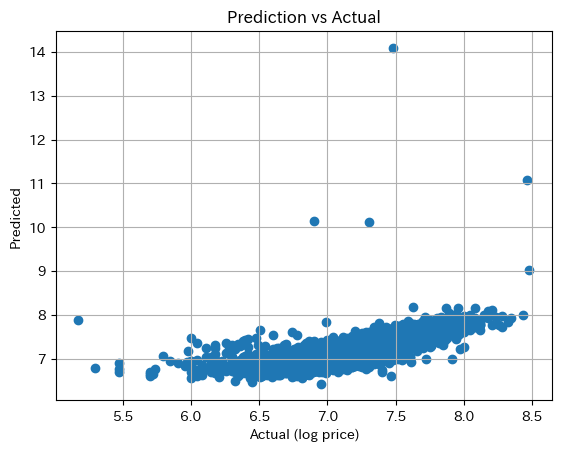

In [84]:
#  作成した重回帰分析モデルの図示
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel('Actual (log price)')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual')
plt.grid(True)
plt.show()

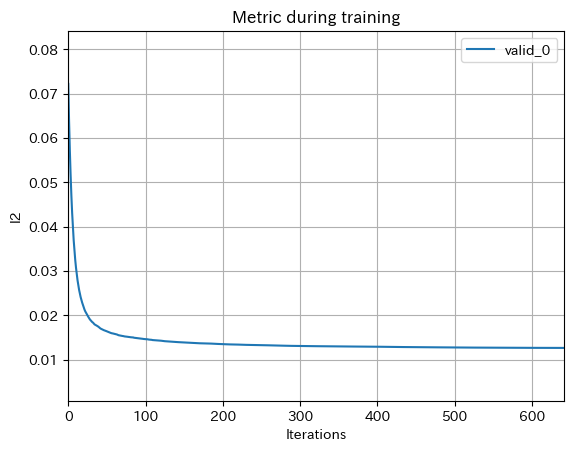

In [85]:
plt.show(lgb.plot_metric(model))

<Figure size 1500x1500 with 0 Axes>

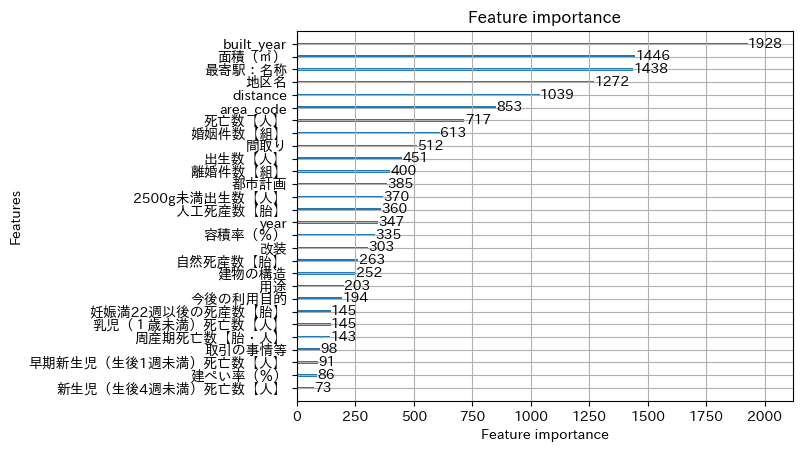

In [86]:
plt.figure(figsize=(15, 15))
lgb.plot_importance(model)
plt.show()

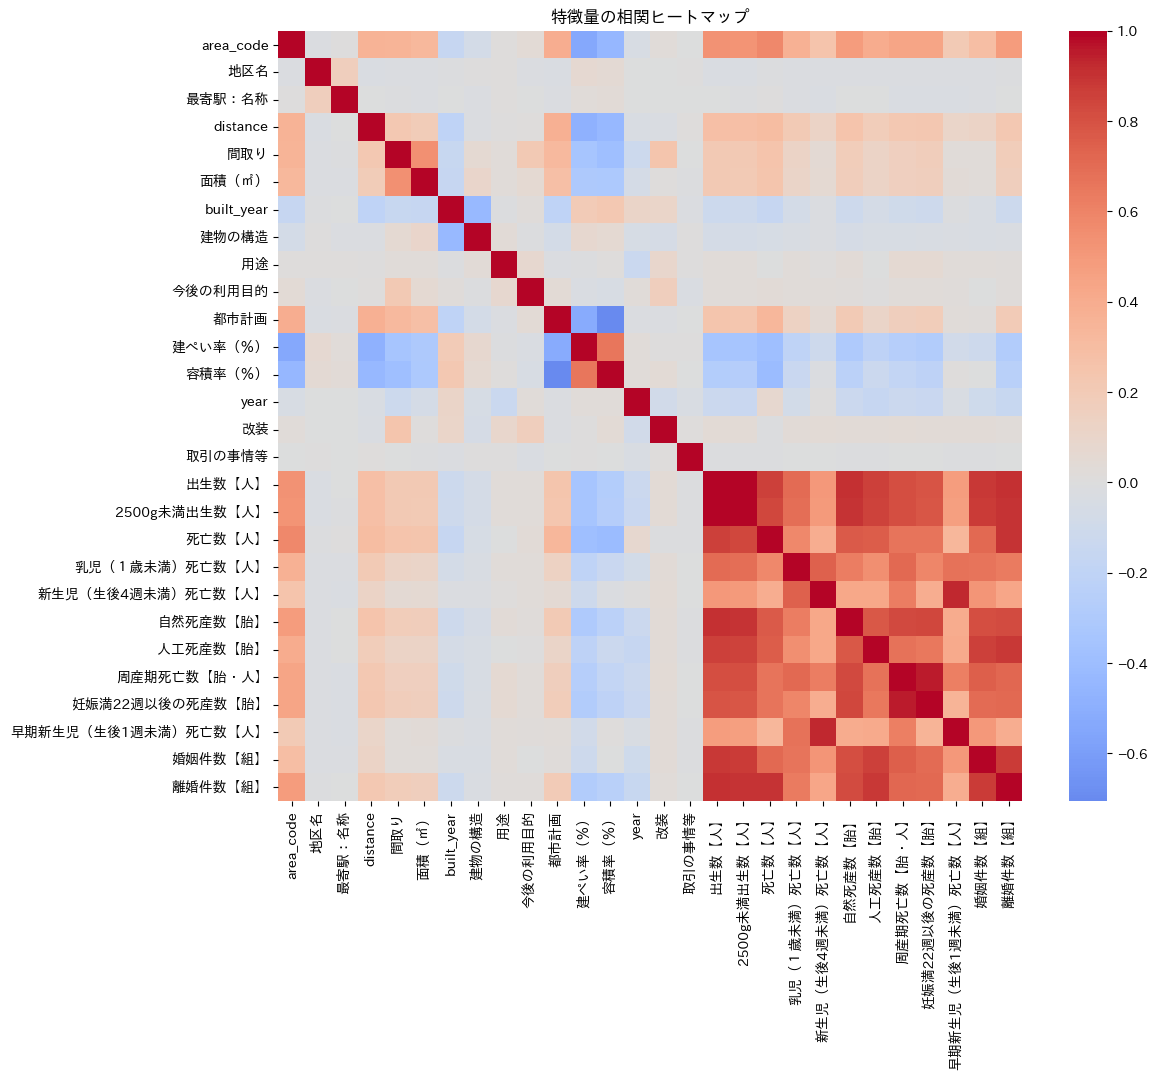

In [87]:
corr_matrix = X.select_dtypes(include='number').corr()

# 相関行列のヒートマップ表示
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('特徴量の相関ヒートマップ')
plt.show()


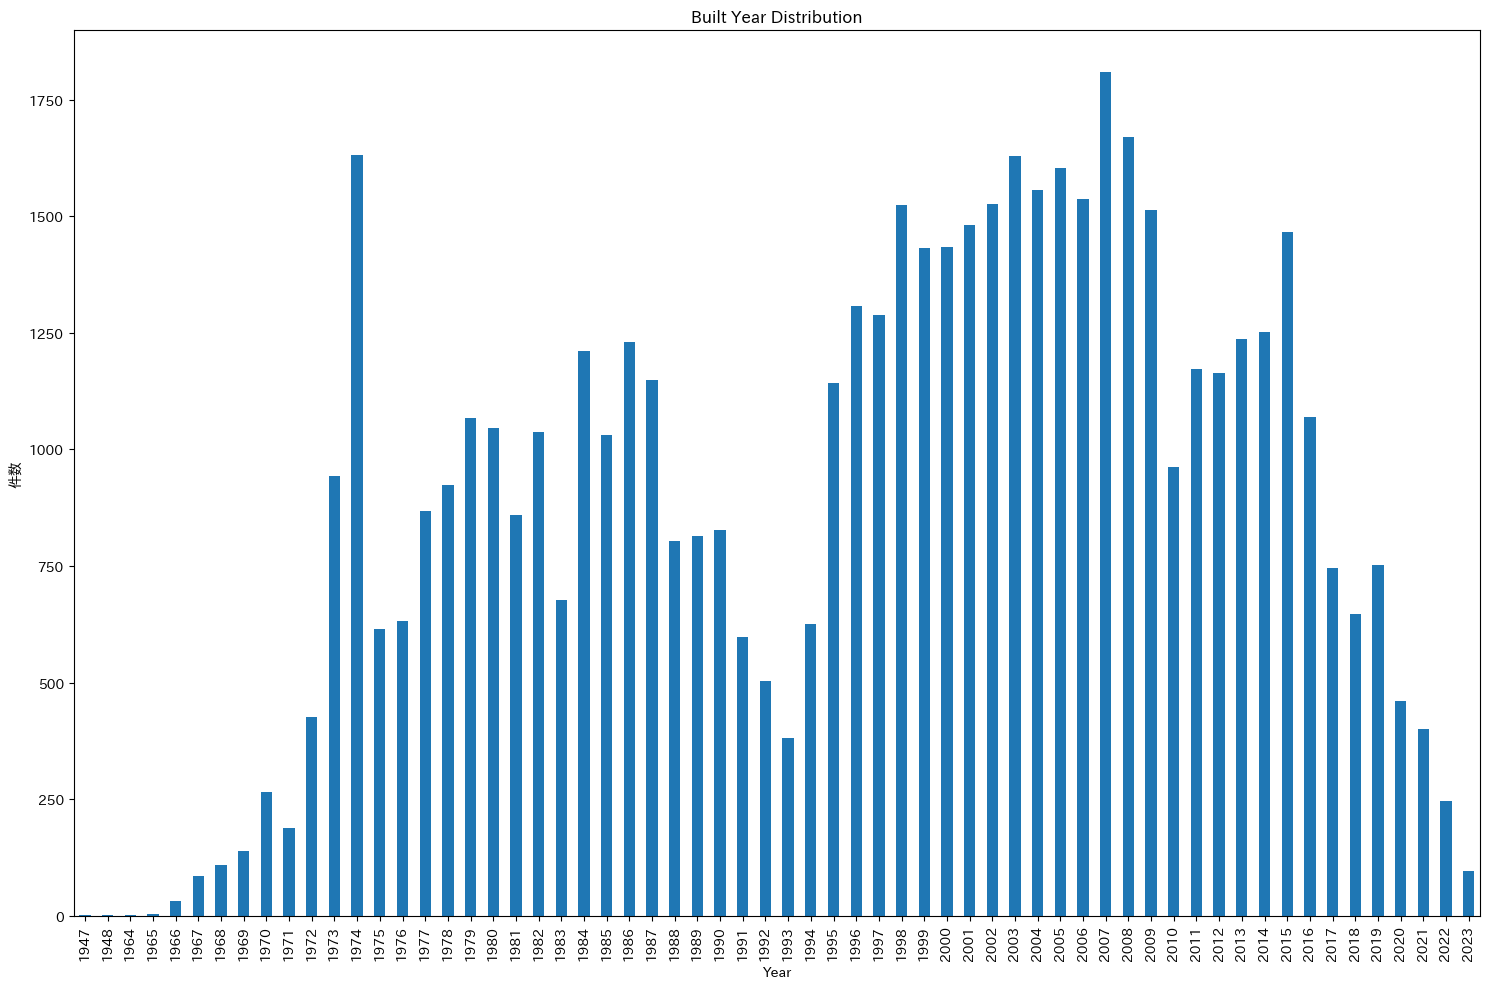

In [88]:
# built_yearの分布（ヒストグラム）
# built_yearのユニークな値を昇順に取得
sorted_years = sorted(df_redemo['built_year'].dropna().unique())

# 年代ごとの件数を集計して並び替え
year_counts = df_redemo['built_year'].value_counts().reindex(sorted_years)

plt.figure(figsize=(15,10))
year_counts.plot(kind='bar')
plt.title('Built Year Distribution')
plt.xlabel('Year')
plt.ylabel('件数')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [89]:
# SHAP用の explainer インスタンスを作成
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)  # X = 学習データの特徴量

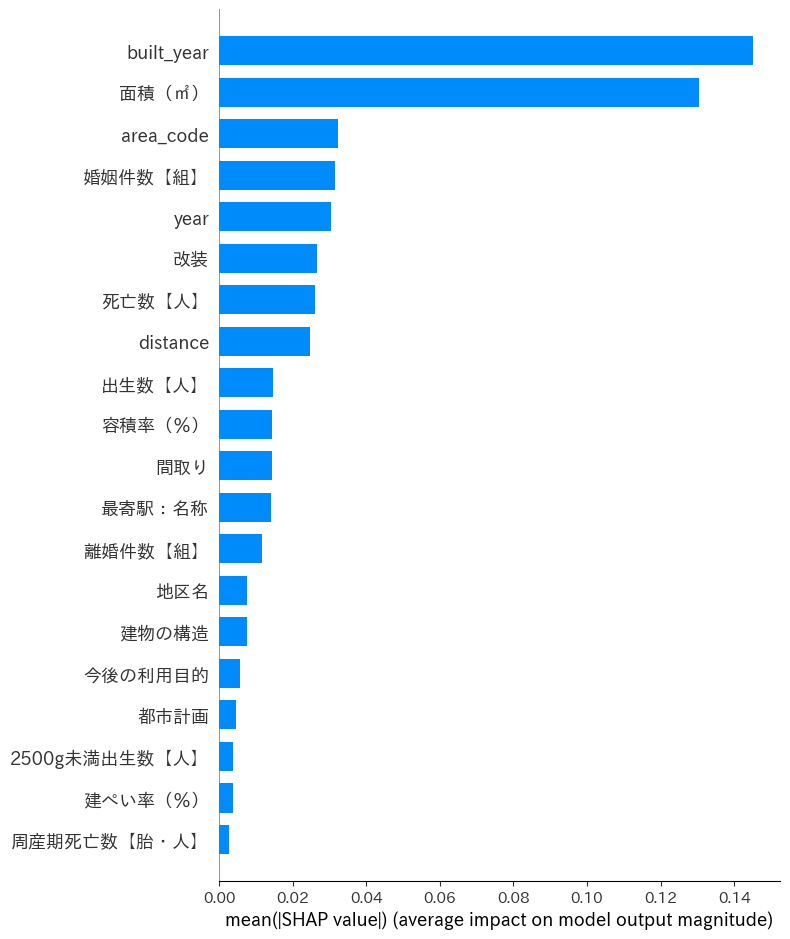

In [90]:
# 要約プロット（各特徴の影響度をまとめたグラフ）
shap.summary_plot(shap_values, X, plot_type="bar")

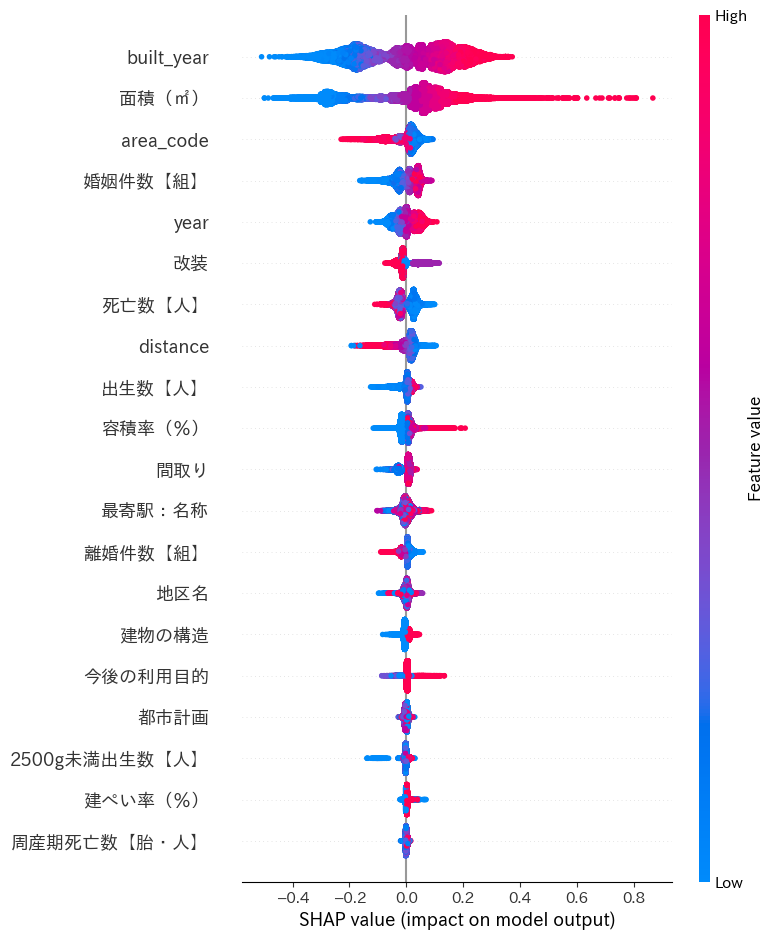

In [91]:
# 詳細プロット（特徴量の値に応じた影響も表示）
shap.summary_plot(shap_values, X)

/tmp/ipykernel_1697/616900637.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


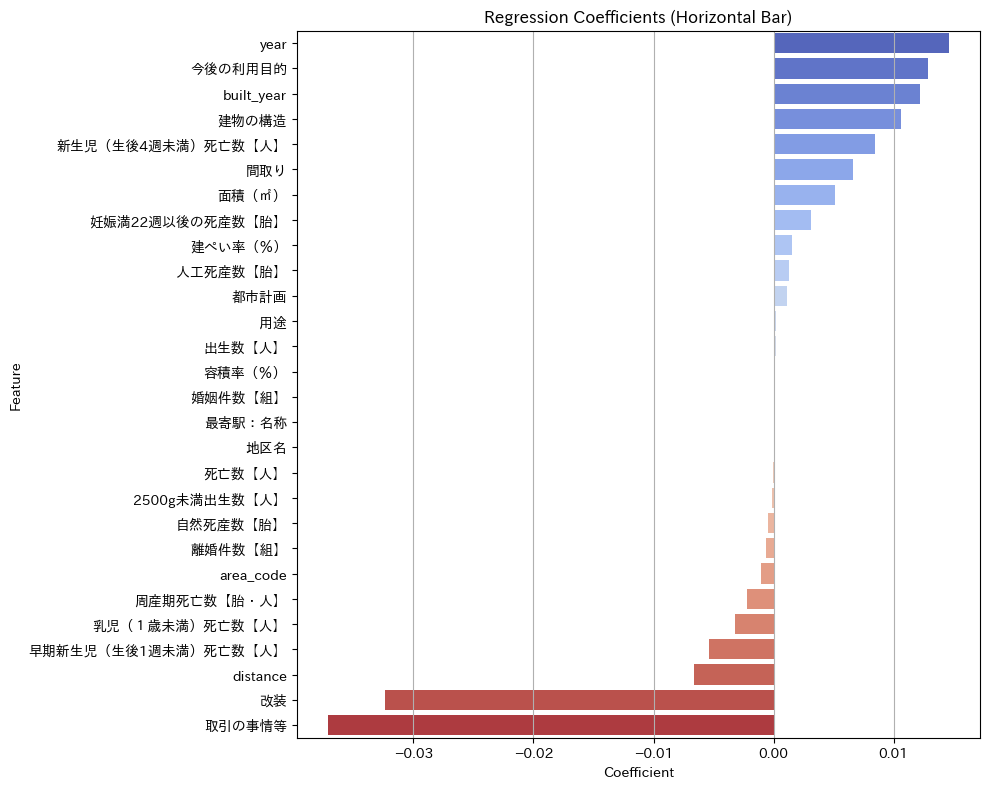

In [92]:
# 作成した重回帰分析モデルの詳細を確認
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model_reg.coef_
})
sort_df = coef_df.sort_values('coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='coefficient',
    y='feature',
    data=sort_df,
    palette='coolwarm'
)
plt.title('Regression Coefficients (Horizontal Bar)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

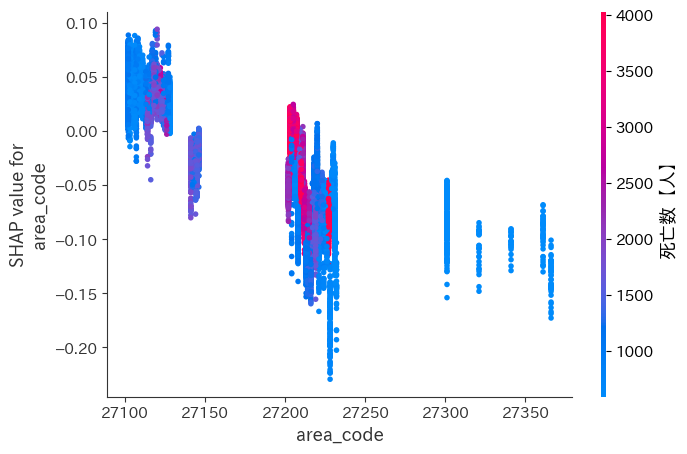

In [93]:
shap.dependence_plot(ind='area_code', shap_values=shap_values, features=X, interaction_index='死亡数【人】')

In [94]:
# 人口自体は国勢調査(5年毎)しかないので、他の切り口で考えてみる。

        area  婚姻件数【組】
641   大阪市都島区      587
2892  大阪市福島区      654
4746  大阪市此花区      314
6362   大阪市西区      937
9632   大阪市港区      410
area       object
婚姻件数【組】     Int64
dtype: object


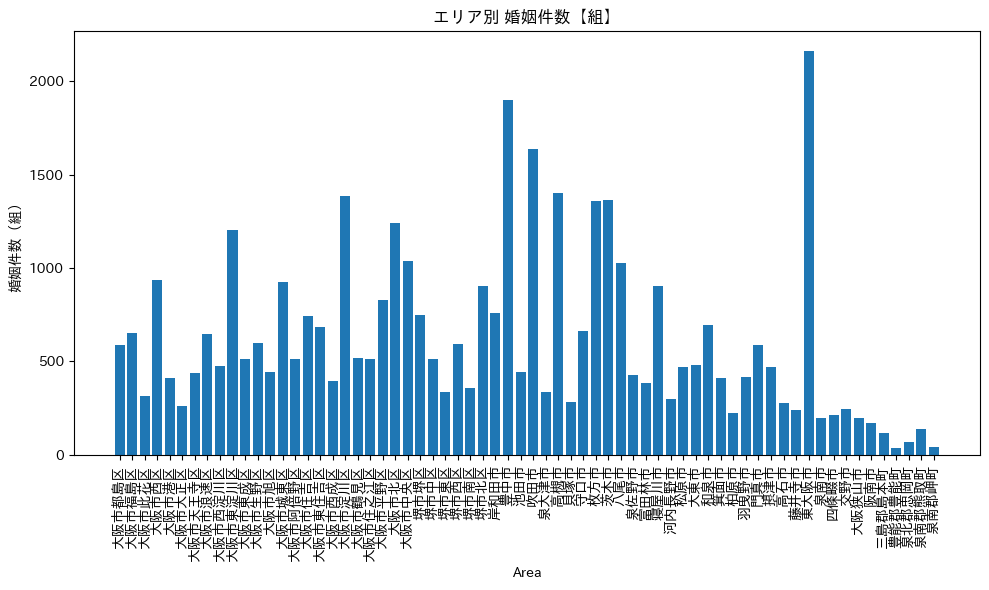

In [95]:
df_marry_2020 = df_redemo_pre[df_redemo_pre['year'] == 2020]
df_marry_2020 = df_marry_2020[['area', '婚姻件数【組】']]
df_marry_2020 = df_marry_2020.drop_duplicates(subset=['area', '婚姻件数【組】'])
df_marry_2020['婚姻件数【組】'] = pd.to_numeric(df_marry_2020['婚姻件数【組】'], errors='coerce')

print(df_marry_2020.head())
print(df_marry_2020.dtypes)

plt.figure(figsize=(10, 6))
plt.bar(df_marry_2020['area'], df_marry_2020['婚姻件数【組】'])
plt.xticks(rotation=90)  # 地域名が重ならないよう回転
plt.title('エリア別 婚姻件数【組】')
plt.xlabel('Area')
plt.ylabel('婚姻件数（組）')
plt.tight_layout()
plt.show()

        area  離婚件数【組】
641   大阪市都島区      186
2892  大阪市福島区      109
4746  大阪市此花区      117
6362   大阪市西区      226
9632   大阪市港区      154
area       object
離婚件数【組】     Int64
dtype: object


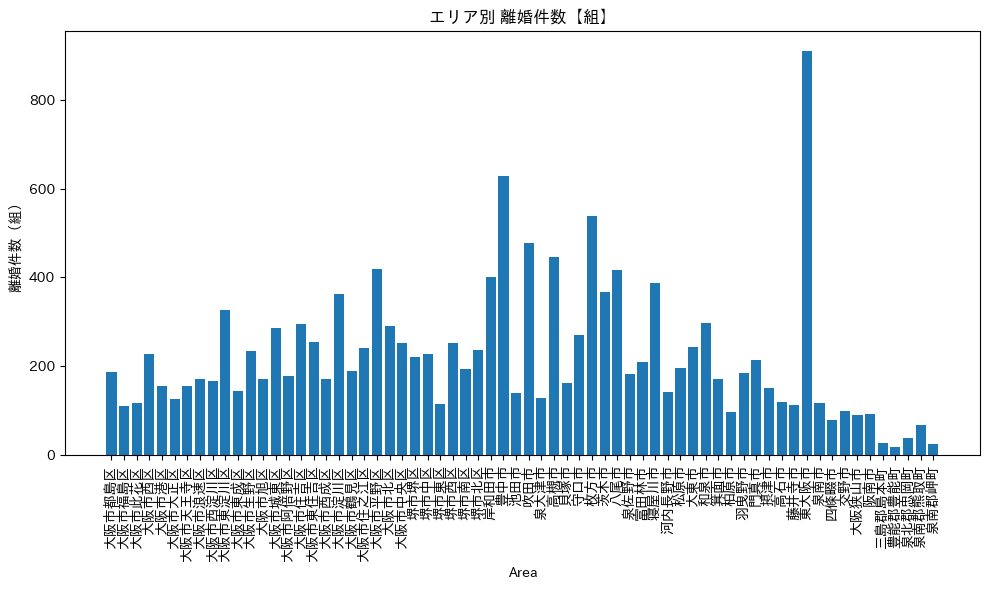

In [96]:
df_divorce_2020 = df_redemo_pre[df_redemo_pre['year'] == 2020]
df_divorce_2020 = df_divorce_2020[['area', '離婚件数【組】']]
df_divorce_2020 = df_divorce_2020.drop_duplicates(subset=['area', '離婚件数【組】'])
df_divorce_2020['離婚件数【組】'] = pd.to_numeric(df_divorce_2020['離婚件数【組】'], errors='coerce')

print(df_divorce_2020.head())
print(df_divorce_2020.dtypes)

plt.figure(figsize=(10, 6))
plt.bar(df_divorce_2020['area'], df_divorce_2020['離婚件数【組】'])
plt.xticks(rotation=90)  # 地域名が重ならないよう回転
plt.title('エリア別 離婚件数【組】')
plt.xlabel('Area')
plt.ylabel('離婚件数（組）')
plt.tight_layout()
plt.show()

        area  死亡数【人】
641   大阪市都島区    1126
2892  大阪市福島区     545
4746  大阪市此花区     745
6362   大阪市西区     628
9632   大阪市港区     981
area      object
死亡数【人】     Int64
dtype: object


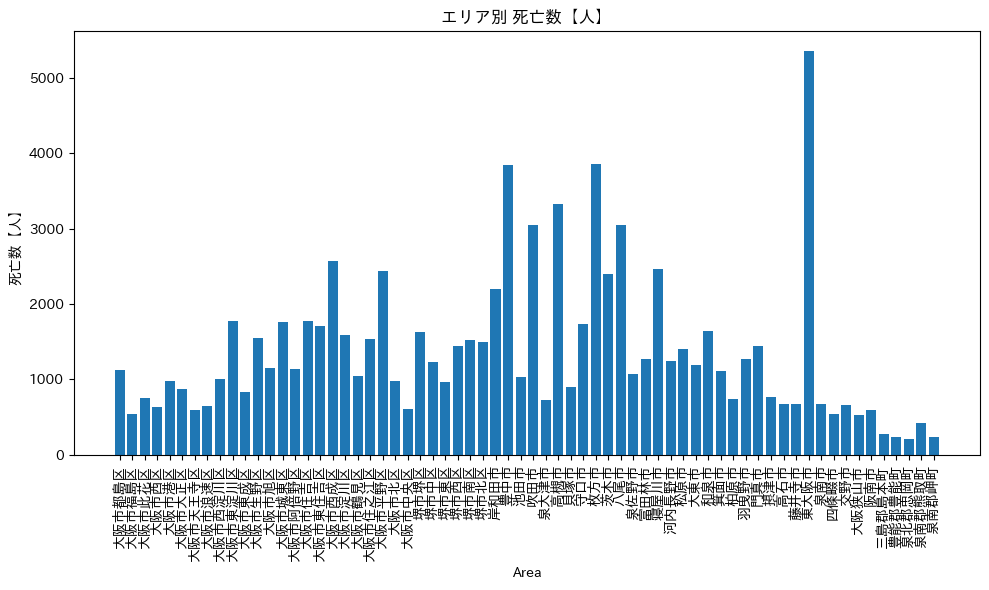

In [97]:
df_dratio_2020 = df_redemo_pre[df_redemo_pre['year'] == 2020]
df_dratio_2020 = df_dratio_2020[['area', '死亡数【人】']]
df_dratio_2020 = df_dratio_2020.drop_duplicates(subset=['area', '死亡数【人】'])
df_dratio_2020['死亡数【人】'] = pd.to_numeric(df_dratio_2020['死亡数【人】'], errors='coerce')

print(df_dratio_2020.head())
print(df_dratio_2020.dtypes)

plt.figure(figsize=(10, 6))
plt.bar(df_dratio_2020['area'], df_dratio_2020['死亡数【人】'])
plt.xticks(rotation=90)  # 地域名が重ならないよう回転
plt.title('エリア別 死亡数【人】')
plt.xlabel('Area')
plt.ylabel('死亡数【人】')
plt.tight_layout()
plt.show()

In [98]:
# 他の深層学習モデルで関連性を検証(XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [99]:
params = {
    "objective": "reg:squarederror",  # 回帰用
    "eval_metric": "rmse"
}
model_xgb = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "test")])

[0]	test-rmse:0.23278
[1]	test-rmse:0.19791
[2]	test-rmse:0.17559
[3]	test-rmse:0.16094
[4]	test-rmse:0.15151
[5]	test-rmse:0.14480
[6]	test-rmse:0.14049
[7]	test-rmse:0.13653
[8]	test-rmse:0.13397
[9]	test-rmse:0.13217
[10]	test-rmse:0.13088
[11]	test-rmse:0.12944
[12]	test-rmse:0.12842
[13]	test-rmse:0.12745
[14]	test-rmse:0.12701
[15]	test-rmse:0.12595
[16]	test-rmse:0.12534
[17]	test-rmse:0.12478
[18]	test-rmse:0.12384
[19]	test-rmse:0.12335
[20]	test-rmse:0.12299
[21]	test-rmse:0.12266
[22]	test-rmse:0.12225
[23]	test-rmse:0.12189
[24]	test-rmse:0.12173
[25]	test-rmse:0.12125
[26]	test-rmse:0.12109
[27]	test-rmse:0.12060
[28]	test-rmse:0.12044
[29]	test-rmse:0.12018
[30]	test-rmse:0.11985
[31]	test-rmse:0.11962
[32]	test-rmse:0.11932
[33]	test-rmse:0.11894
[34]	test-rmse:0.11877
[35]	test-rmse:0.11869
[36]	test-rmse:0.11858
[37]	test-rmse:0.11859
[38]	test-rmse:0.11860
[39]	test-rmse:0.11857
[40]	test-rmse:0.11853
[41]	test-rmse:0.11843
[42]	test-rmse:0.11828
[43]	test-rmse:0.1181

In [100]:
preds_xgb = model_xgb.predict(dtest)
print("RMSE :", mean_squared_error(y_test, preds_xgb))
print("MAE :", mean_absolute_error(y_test, preds_xgb))
print("R2  :", r2_score(y_test, preds_xgb))

RMSE : 0.013380367317654037
MAE : 0.0732333443209177
R2  : 0.836982932892373


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

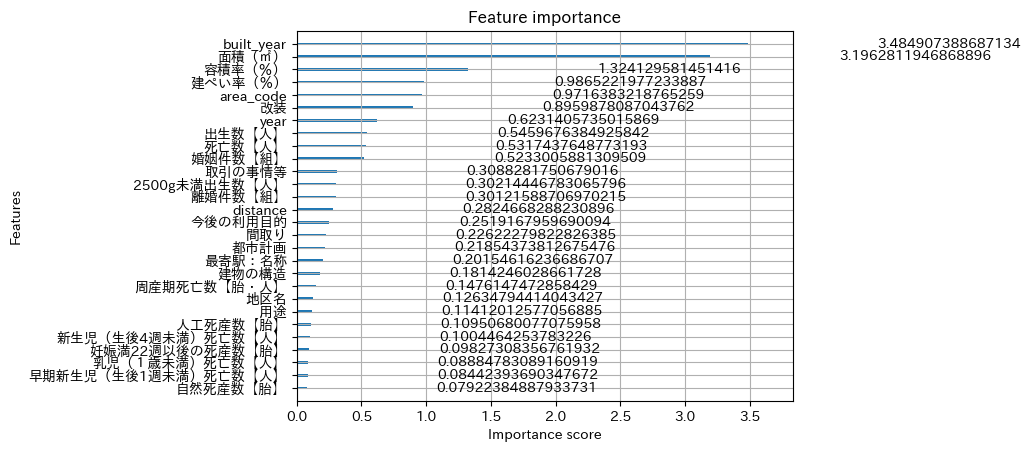

In [101]:
xgb.plot_importance(model_xgb, importance_type="gain")

In [102]:
# SHAP用の explainer インスタンスを作成
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X)  # X = 学習データの特徴量

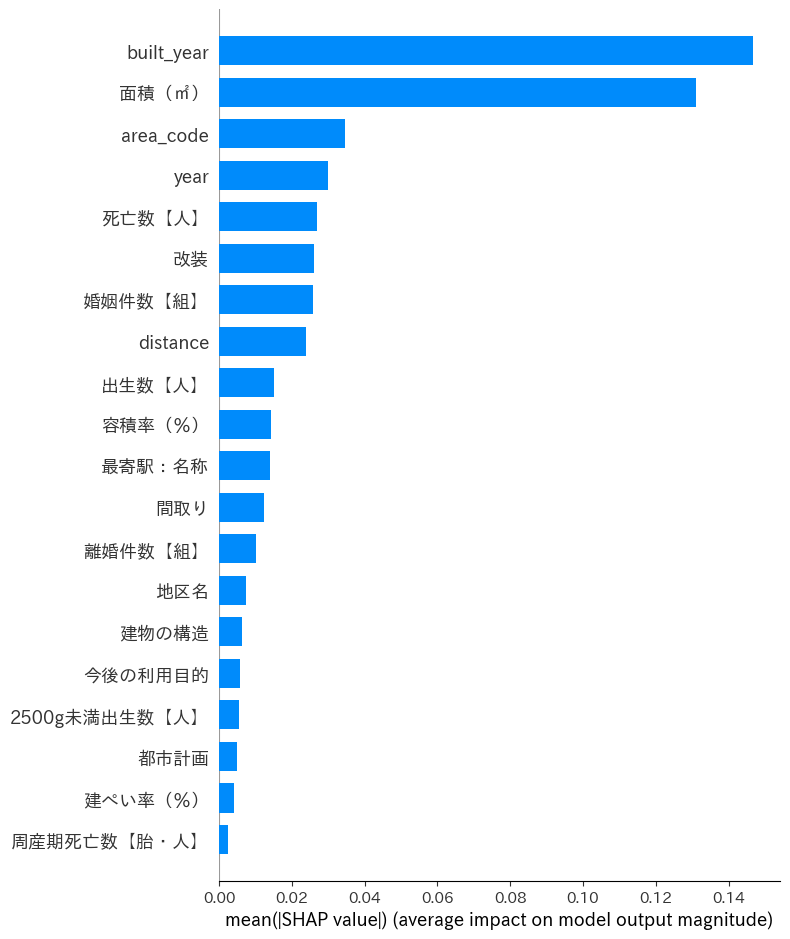

In [103]:
# 要約プロット（各特徴の影響度をまとめたグラフ）
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

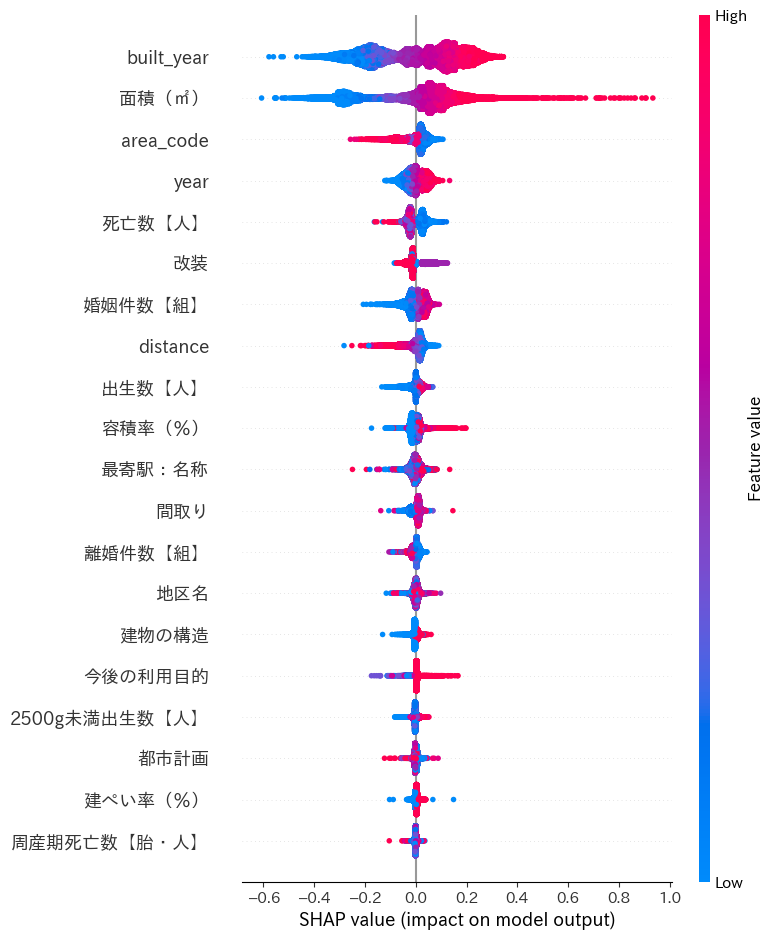

In [104]:
# 詳細プロット（特徴量の値に応じた影響も表示）
shap.summary_plot(shap_values_xgb, X)

In [105]:
model_tabnet = TabNetRegressor()
model_tabnet.fit(
    X_train=X_train.values, y_train=y_train.values.reshape(-1, 1),
    eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
    eval_metric=['rmse'],       # ← 回帰指標に変更
)

/home/shizuku/re-voltage/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.36783 | val_0_rmse: 715.5406|  0:00:02s
epoch 1  | loss: 0.09831 | val_0_rmse: 29.80211|  0:00:04s
epoch 2  | loss: 0.07505 | val_0_rmse: 24.72446|  0:00:06s
epoch 3  | loss: 0.06175 | val_0_rmse: 15.01455|  0:00:08s
epoch 4  | loss: 0.05624 | val_0_rmse: 10.13628|  0:00:10s
epoch 5  | loss: 0.05108 | val_0_rmse: 7.16514 |  0:00:12s
epoch 6  | loss: 0.04728 | val_0_rmse: 3.95817 |  0:00:14s
epoch 7  | loss: 0.04433 | val_0_rmse: 2.89928 |  0:00:16s
epoch 8  | loss: 0.04302 | val_0_rmse: 2.31183 |  0:00:18s
epoch 9  | loss: 0.04139 | val_0_rmse: 1.25027 |  0:00:20s
epoch 10 | loss: 0.03822 | val_0_rmse: 0.91551 |  0:00:22s
epoch 11 | loss: 0.03564 | val_0_rmse: 0.57026 |  0:00:24s
epoch 12 | loss: 0.03515 | val_0_rmse: 0.39861 |  0:00:27s
epoch 13 | loss: 0.03295 | val_0_rmse: 0.40733 |  0:00:29s
epoch 14 | loss: 0.03035 | val_0_rmse: 0.30805 |  0:00:31s
epoch 15 | loss: 0.02862 | val_0_rmse: 0.22728 |  0:00:33s
epoch 16 | loss: 0.02913 | val_0_rmse: 0.19522 |  0:00:3

/home/shizuku/re-voltage/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [106]:
print(X_train.dtypes)

area_code              int64
地区名                    int64
最寄駅：名称                 int64
distance               int64
間取り                    int64
面積（㎡）                  int64
built_year             int64
建物の構造                  int64
用途                     int64
今後の利用目的                int64
都市計画                   int64
建ぺい率（％）                int64
容積率（％）                 int64
year                   int64
改装                     int64
取引の事情等                 int64
出生数【人】                 int64
2500g未満出生数【人】          int64
死亡数【人】                 int64
乳児（１歳未満）死亡数【人】         int64
新生児（生後4週未満）死亡数【人】      int64
自然死産数【胎】               int64
人工死産数【胎】               int64
周産期死亡数【胎・人】            int64
妊娠満22週以後の死産数【胎】        int64
早期新生児（生後1週未満）死亡数【人】    int64
婚姻件数【組】                int64
離婚件数【組】                int64
dtype: object


In [107]:
preds_tabnet = model_tabnet.predict(X_test.values)

print("RMSE:", mean_squared_error(y_test, preds_tabnet))
print("MAE :", mean_absolute_error(y_test, preds_tabnet))
print("R²  :", r2_score(y_test, preds_tabnet))

RMSE: 0.020425308276105093
MAE : 0.09771687552421844
R²  : 0.7511522837234351


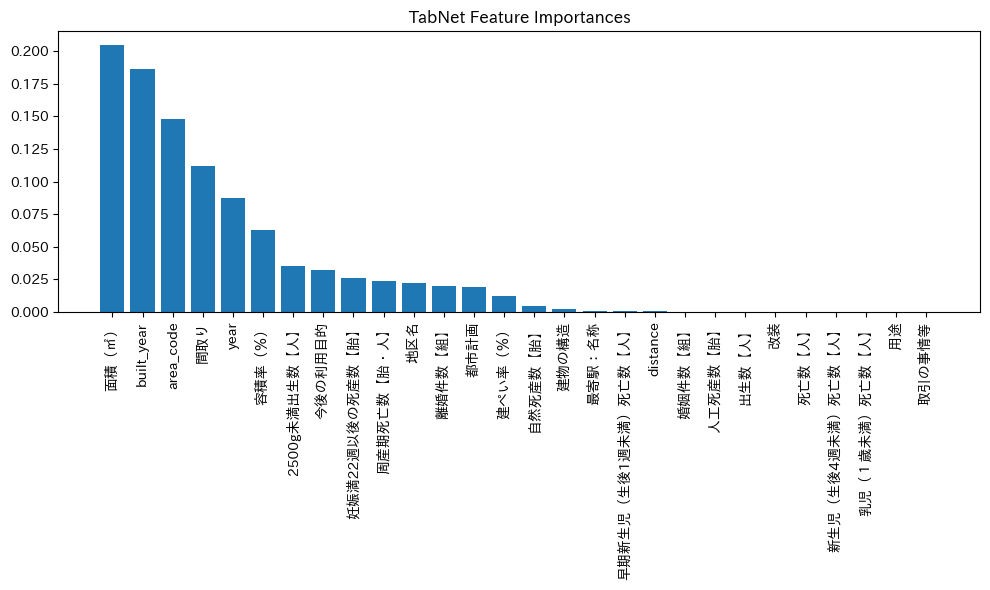

In [108]:
importances = model_tabnet.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("TabNet Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

In [109]:
# 適当なデータを用いて予測してみる
X_kaizuka = X[X['area_code'] == 27208]
print(X_kaizuka.mean())

area_code              27208.000000
地区名                      683.826772
最寄駅：名称                   258.015748
distance                  10.055118
間取り                       21.047244
面積（㎡）                     70.964567
built_year              1992.775591
建物の構造                      4.311024
用途                         2.740157
今後の利用目的                    2.527559
都市計画                       8.846457
建ぺい率（％）                   60.433071
容積率（％）                   203.543307
year                    2019.496063
改装                         1.118110
取引の事情等                     0.062992
出生数【人】                   533.196850
2500g未満出生数【人】             48.602362
死亡数【人】                   941.559055
乳児（１歳未満）死亡数【人】             1.311024
新生児（生後4週未満）死亡数【人】          0.720472
自然死産数【胎】                   5.972441
人工死産数【胎】                   6.996063
周産期死亡数【胎・人】                2.007874
妊娠満22週以後の死産数【胎】            1.685039
早期新生児（生後1週未満）死亡数【人】        0.322835
婚姻件数【組】                  297.066929
離婚件数【組】                  153

In [112]:
print(X_kaizuka.head())

       area_code   地区名  最寄駅：名称  distance  間取り  面積（㎡）  built_year  建物の構造  用途  \
64923      27208  1009     372         6   24     75        1997      3   4   
64924      27208  1009     372         7    0     75        1997      3   4   
64925      27208  1009     372         5   17     65        1997      3   4   
64926      27208  1009     372         5   17     65        1997      3   4   
64927      27208  1009     372         5   24     85        1997      3   4   

       今後の利用目的  ...  死亡数【人】  乳児（１歳未満）死亡数【人】  新生児（生後4週未満）死亡数【人】  自然死産数【胎】  \
64923        3  ...    1079               1                  0         4   
64924        3  ...    1079               1                  0         4   
64925        3  ...     944               1                  1         6   
64926        3  ...     944               1                  1         6   
64927        3  ...     885               1                  1         9   

       人工死産数【胎】  周産期死亡数【胎・人】  妊娠満22週以後の死産数【胎】  早期新生児（生後1週未満）死亡数【人】  

In [137]:
new_data = pd.DataFrame({
    # 必要な特徴量をすべて揃える
    "area_code": [27208], #貝塚
    "地区名": [1009], #海塚
    "最寄駅：名称": [372], #貝塚(大阪)
    "distance": [10],
    "間取り": [17], #2LDK
    "面積（㎡）": [71],
    "built_year": [1993],
    "建物の構造": [1], #木造
    "用途": [4], #住宅
    "今後の利用目的": [3], #住宅
    "都市計画": [9], #１低住専
    "建ぺい率（％）": [60],
    "容積率（％）": [204],
    "year": [2020],
    "改装": [1], #階層済み
    "取引の事情等": [0], #nan
    "出生数【人】": [533],
    "2500g未満出生数【人】": [49],
    "死亡数【人】": [942],
    "乳児（１歳未満）死亡数【人】": [1],
    "新生児（生後4週未満）死亡数【人】": [1],
    "自然死産数【胎】": [6],
    "人工死産数【胎】": [7],
    "周産期死亡数【胎・人】": [2],
    "妊娠満22週以後の死産数【胎】": [1],
    "早期新生児（生後1週未満）死亡数【人】": [0],
    "婚姻件数【組】": [297],
    "離婚件数【組】": [154],
})


In [135]:
df_redemo[df_redemo['area_code'] == 27208].to_csv('area_detail.csv', index=False, encoding='utf-8')

In [131]:
for i, cat in enumerate(encoder.categories_):
    print(f"{cat} -> {i}")

['中古マンション等'] -> 0
['不動産取引価格情報'] -> 1
['大阪府'] -> 2
['いぶき野' 'ときわ台' 'なぎさ町' ... '黒田' '龍華町' '龍造寺町'] -> 3
['あびこ' 'だいどう豊里' 'ときわ台(大阪)' 'なかもず(大阪メトロ)' 'なにわ橋' 'なんば(大阪メトロ)' 'みさき公園'
 'コスモスクエア' 'トレードセンター前' 'ドーム前' 'ドーム前千代崎' 'ポートタウン東' 'ポートタウン西' 'ユニバーサルシティ'
 '七道' '万博記念公園(大阪)' '三国(大阪)' '三国ケ丘' '三日市町' '上新庄' '上牧(大阪)' '上野芝' '下新庄'
 '下松(大阪)' '中ふ頭' '中之島' '中崎町' '中津(大阪メトロ)' '中津(阪急)' '中百舌鳥(南海・泉北)' '久宝寺'
 '久宝寺口' '久米田' '九条(大阪メトロ)' '九条(阪神)' '二色浜' '井原里' '井高野' '交野市' '京橋(大阪)' '今宮'
 '今宮戎' '今川(大阪)' '今福鶴見' '今里(大阪メトロ)' '今里(近鉄)' '伝法' '伽羅橋' '住ノ江' '住之江公園'
 '住吉(大阪)' '住吉大社' '住吉東' '住道' '俊徳道' '信太山' '光善寺' '光明池' '光風台(大阪)' '八尾' '八尾南'
 '八戸ノ里' '公園東口' '出戸' '出来島' '初芝' '加島' '加美' '動物園前' '北信太' '北加賀屋' '北助松' '北千里'
 '北天下茶屋' '北巽' '北新地' '北浜(大阪)' '北田辺' '北畠' '北花田' '北野田' '十三' '千代田' '千林' '千林大宮'
 '千船' '千里丘' '千里中央' '千里山' '千鳥橋' '南千里' '南吹田' '南巽' '南摂津' '南方(大阪)' '南森町' '南港口'
 '南田辺' '南茨木' '古川橋' '古市(大阪)' '吉田(大阪)' '吉見ノ里' '吹田(阪急)' '吹田(ＪＲ)' '和泉中央'
 '和泉大宮' '和泉府中' '和泉橋本' '和泉砂川' '喜志' '喜連瓜破' '四ツ橋' '四天王寺前夕陽ケ丘' '四条畷' '園田' '土居'
 '土師ノ里' '城北公園通' '堅下' '堺' '堺市' '堺東' '堺筋本

In [138]:
predicted_value = 10 ** model.predict(new_data)
print(f"予測値: {predicted_value[0]:.2f} 円")

予測値: 10453463.41 円
